In [ ]:
pip install pandas numpy matplotlib seaborn scikit-learn statsmodels tensorflow keras


In [ ]:
from google.colab import files
uploaded = files.upload()   # Upload energy.csv from your PC



Saving AEP_hourly.csv to AEP_hourly.csv
Saving COMED_hourly.csv to COMED_hourly.csv
Saving DAYTON_hourly.csv to DAYTON_hourly.csv
Saving DEOK_hourly.csv to DEOK_hourly.csv
Saving DOM_hourly.csv to DOM_hourly.csv
Saving DUQ_hourly.csv to DUQ_hourly.csv
Saving EKPC_hourly.csv to EKPC_hourly.csv
Saving est_hourly.paruqet to est_hourly.paruqet
Saving FE_hourly.csv to FE_hourly.csv
Saving NI_hourly.csv to NI_hourly.csv
Saving pjm_hourly_est.csv to pjm_hourly_est.csv
Saving PJM_Load_hourly.csv to PJM_Load_hourly.csv
Saving PJME_hourly.csv to PJME_hourly.csv
Saving PJMW_hourly.csv to PJMW_hourly.csv


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [8]:
# Load AEP dataset
df = pd.read_csv("AEP_hourly.csv")

# Check first rows
print(df.head())
print(df.info())


              Datetime   AEP_MW
0  2004-12-31 01:00:00  13478.0
1  2004-12-31 02:00:00  12865.0
2  2004-12-31 03:00:00  12577.0
3  2004-12-31 04:00:00  12517.0
4  2004-12-31 05:00:00  12670.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  121273 non-null  object 
 1   AEP_MW    121273 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB
None


In [9]:
# Rename columns
df.columns = ["Datetime", "Value"]

# Convert to datetime
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Set datetime as index
df.set_index("Datetime", inplace=True)

# Check missing values
print("Missing values:", df.isna().sum())

# Fill missing values by interpolation (if any)
df = df.resample('H').mean().interpolate()


Missing values: Value    0
dtype: int64


/tmp/ipython-input-1526132263.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample('H').mean().interpolate()


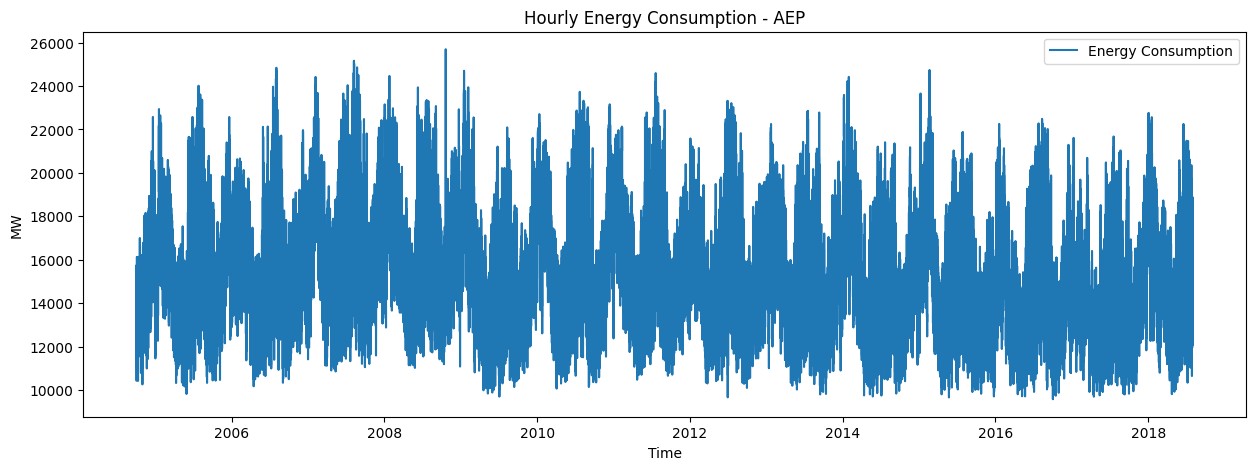

In [10]:
plt.figure(figsize=(15,5))
plt.plot(df['Value'], label="Energy Consumption")
plt.title("Hourly Energy Consumption - AEP")
plt.xlabel("Time")
plt.ylabel("MW")
plt.legend()
plt.show()


In [12]:
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA RMSE: 3041.3942189123586
ARIMA MAE: 2358.579457872431


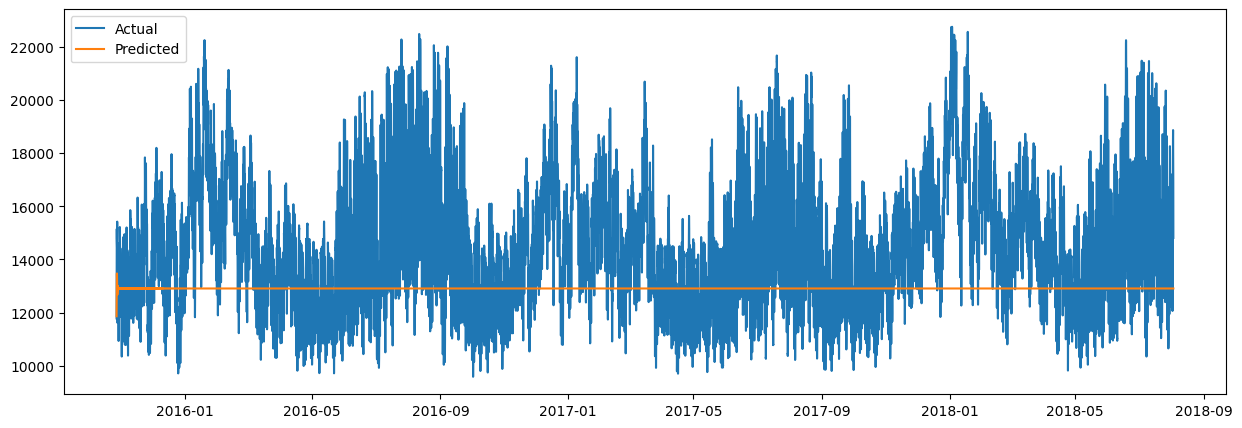

In [13]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA (order chosen arbitrarily, later we can tune)
model = ARIMA(train['Value'], order=(5,1,2))
fit = model.fit()

# Forecast
forecast = fit.forecast(steps=len(test))

# Evaluate
rmse = np.sqrt(mean_squared_error(test['Value'], forecast))
mae = mean_absolute_error(test['Value'], forecast)
print("ARIMA RMSE:", rmse)
print("ARIMA MAE:", mae)

# Plot
plt.figure(figsize=(15,5))
plt.plot(test.index, test['Value'], label="Actual")
plt.plot(test.index, forecast, label="Predicted")
plt.legend()
plt.show()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 68s 21ms/step - loss: 0.0053
Epoch 2/10
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 82s 21ms/step - loss: 3.9122e-04
Epoch 3/10
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 64s 21ms/step - loss: 3.2022e-04
Epoch 4/10
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 83s 21ms/step - loss: 2.6327e-04
Epoch 5/10
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 82s 21ms/step - loss: 2.3975e-04
Epoch 6/10
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 82s 21ms/step - loss: 1.9851e-04
Epoch 7/10
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 66s 22ms/step - loss: 2.0294e-04
Epoch 8/10
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 83s 22ms/step - loss: 1.7945e-04
Epoch 9/10
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 80s 21ms/step - loss: 1.8372e-04
Epoch 10/10
3032/3032 ━━━━━━━━━━━━━━━━━━━━ 65s 21ms/step - loss: 1.7275e-04
758/758 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step
LSTM RMSE: 210.55079420046116
LSTM MAE: 154.92858165519996


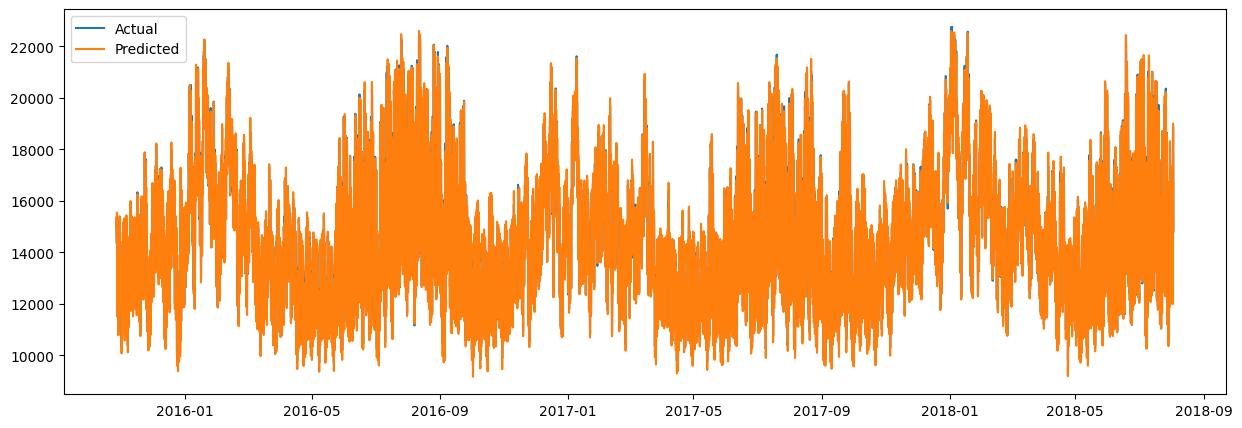

In [17]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Scale data
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[['Value']])

# Create sequences (24 hours history → next value)
X, y = [], []
for i in range(24, len(scaled)):
    X.append(scaled[i-24:i, 0])
    y.append(scaled[i, 0])
X, y = np.array(X), np.array(y)

# Train-test split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(32))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Predict
pred_scaled = model.predict(X_test)
pred = scaler.inverse_transform(pred_scaled)

# Inverse actual
actual = scaler.inverse_transform(y_test.reshape(-1,1))

# Evaluate
rmse_lstm = np.sqrt(mean_squared_error(actual, pred))
mae_lstm = mean_absolute_error(actual, pred)
print("LSTM RMSE:", rmse_lstm)
print("LSTM MAE:", mae_lstm)

# Align lengths
aligned_index = test.index[-len(actual):]

plt.figure(figsize=(15,5))
plt.plot(aligned_index, actual, label="Actual")
plt.plot(aligned_index, pred, label="Predicted")
plt.legend()
plt.show()



In [18]:
print("ARIMA RMSE:", rmse, "MAE:", mae)
print("LSTM  RMSE:", rmse_lstm, "MAE:", mae_lstm)


ARIMA RMSE: 3041.3942189123586 MAE: 2358.579457872431
LSTM  RMSE: 210.55079420046116 MAE: 154.92858165519996


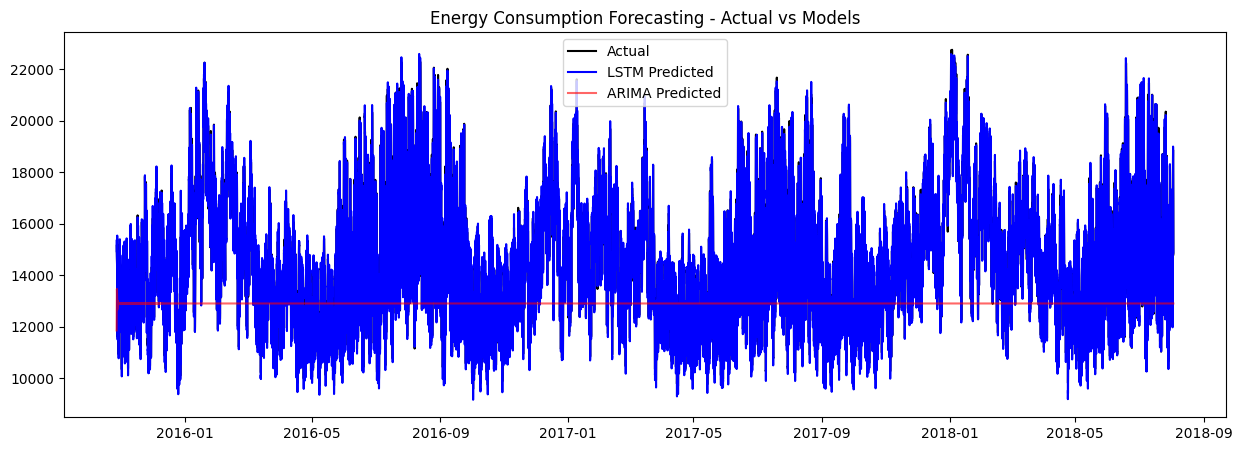

In [19]:
plt.figure(figsize=(15,5))
plt.plot(aligned_index, actual, label="Actual", color='black')
plt.plot(aligned_index, pred, label="LSTM Predicted", color='blue')
plt.plot(test.index, forecast, label="ARIMA Predicted", color='red', alpha=0.6)
plt.legend()
plt.title("Energy Consumption Forecasting - Actual vs Models")
plt.show()


In [20]:
import pandas as pd

# Load PJM region dataset
df = pd.read_csv("PJM_Load_hourly.csv")

# Rename columns
df.columns = ["Datetime", "Value"]

# Convert datetime
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Set datetime as index
df.set_index("Datetime", inplace=True)

# Resample hourly + fill missing values
df = df.resample("H").mean().interpolate()

print(df.head())
print(df.info())


                       Value
Datetime                    
1998-04-01 01:00:00  22259.0
1998-04-01 02:00:00  21244.0
1998-04-01 03:00:00  20651.0
1998-04-01 04:00:00  20421.0
1998-04-01 05:00:00  20713.0
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32904 entries, 1998-04-01 01:00:00 to 2002-01-01 00:00:00
Freq: h
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   32904 non-null  float64
dtypes: float64(1)
memory usage: 514.1 KB
None


/tmp/ipython-input-1889011898.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample("H").mean().interpolate()


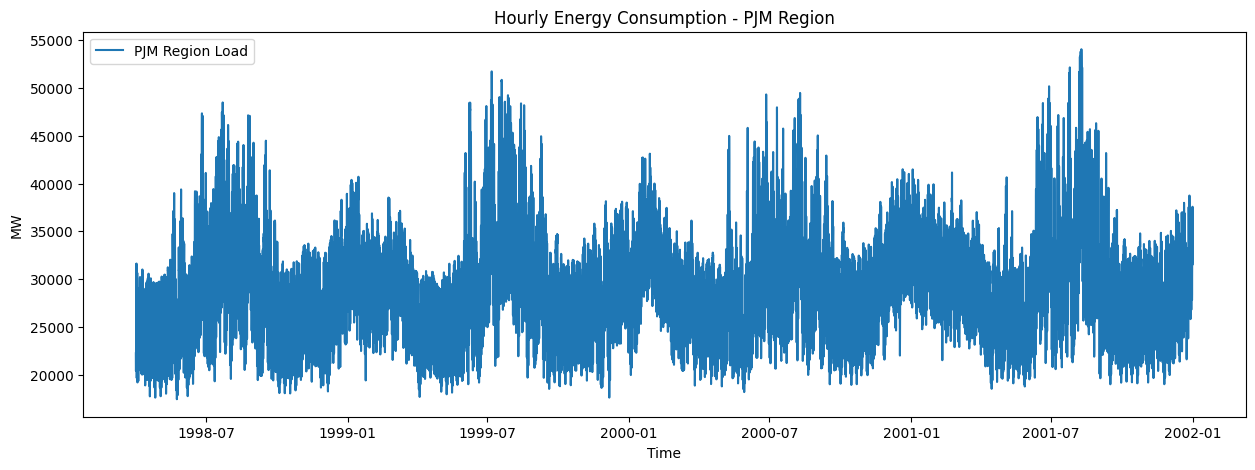

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(df['Value'], label="PJM Region Load")
plt.title("Hourly Energy Consumption - PJM Region")
plt.xlabel("Time")
plt.ylabel("MW")
plt.legend()
plt.show()


In [22]:
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA RMSE: 6982.404522247228
ARIMA MAE: 5305.844526784264


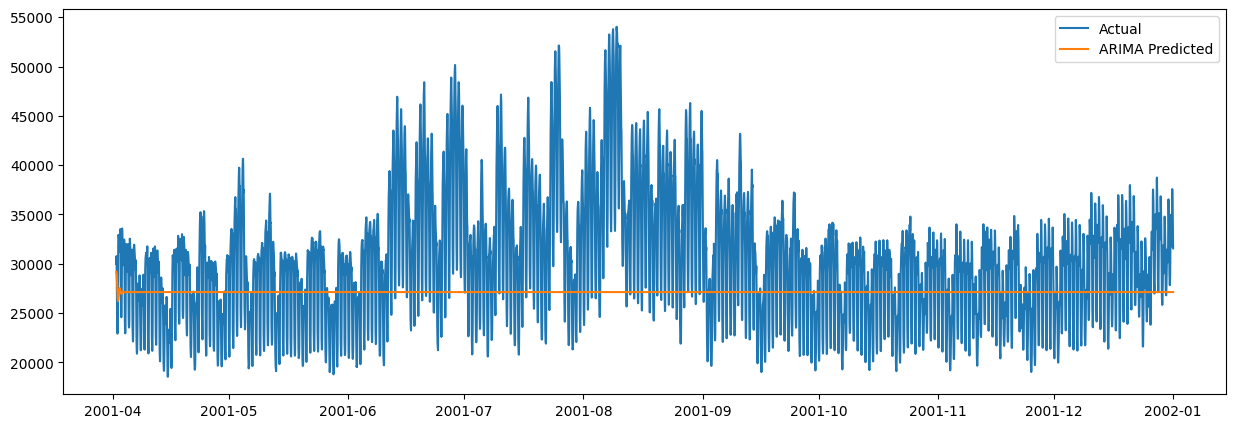

In [23]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Fit ARIMA
model = ARIMA(train['Value'], order=(5,1,2))
fit = model.fit()

# Forecast
forecast = fit.forecast(steps=len(test))

# Evaluate
rmse = np.sqrt(mean_squared_error(test['Value'], forecast))
mae = mean_absolute_error(test['Value'], forecast)
print("ARIMA RMSE:", rmse)
print("ARIMA MAE:", mae)

# Plot
plt.figure(figsize=(15,5))
plt.plot(test.index, test['Value'], label="Actual")
plt.plot(test.index, forecast, label="ARIMA Predicted")
plt.legend()
plt.show()


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


822/822 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - loss: 0.0115
Epoch 2/10
822/822 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 6.7528e-04
Epoch 3/10
822/822 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - loss: 3.9898e-04
Epoch 4/10
822/822 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - loss: 3.9329e-04
Epoch 5/10
822/822 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 3.5911e-04
Epoch 6/10
822/822 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 3.3523e-04
Epoch 7/10
822/822 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 3.2738e-04
Epoch 8/10
822/822 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 3.0283e-04
Epoch 9/10
822/822 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 3.0471e-04
Epoch 10/10
822/822 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 2.9306e-04
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
LSTM RMSE: 630.3132866637736
LSTM MAE: 471.1159973887051


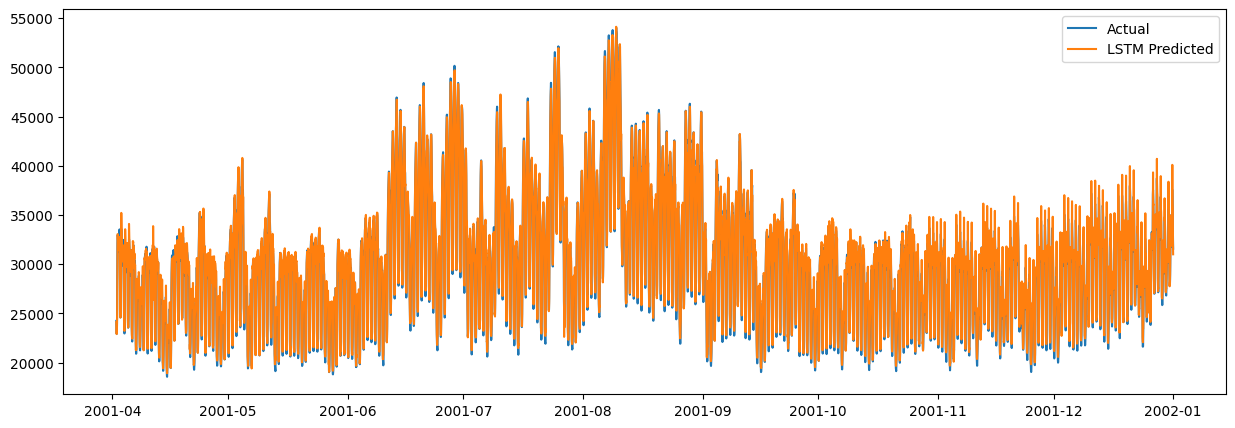

In [24]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Scale
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[['Value']])

# Create sequences (24 hrs → next hr)
X, y = [], []
for i in range(24, len(scaled)):
    X.append(scaled[i-24:i, 0])
    y.append(scaled[i, 0])
X, y = np.array(X), np.array(y)

# Train-test split
split = int(len(X)*0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(32))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Predict
pred_scaled = model.predict(X_test)
pred = scaler.inverse_transform(pred_scaled)

# Inverse actual
actual = scaler.inverse_transform(y_test.reshape(-1,1))

# Align index
aligned_index = test.index[-len(actual):]

# Evaluate
rmse_lstm = np.sqrt(mean_squared_error(actual, pred))
mae_lstm = mean_absolute_error(actual, pred)
print("LSTM RMSE:", rmse_lstm)
print("LSTM MAE:", mae_lstm)

# Plot
plt.figure(figsize=(15,5))
plt.plot(aligned_index, actual, label="Actual")
plt.plot(aligned_index, pred, label="LSTM Predicted")
plt.legend()
plt.show()


In [25]:
print("ARIMA RMSE:", rmse, "MAE:", mae)
print("LSTM  RMSE:", rmse_lstm, "MAE:", mae_lstm)


ARIMA RMSE: 6982.404522247228 MAE: 5305.844526784264
LSTM  RMSE: 630.3132866637736 MAE: 471.1159973887051


In [26]:
import pandas as pd

results = {
    "Model": ["ARIMA", "LSTM"],
    "RMSE": [rmse, rmse_lstm],
    "MAE": [mae, mae_lstm]
}

results_df = pd.DataFrame(results)
print(results_df)


   Model         RMSE          MAE
0  ARIMA  6982.404522  5305.844527
1   LSTM   630.313287   471.115997


/tmp/ipython-input-965633802.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  plt.plot(pd.date_range(df.index[-1], periods=168, freq="H"), future_forecast, label="Future Forecast")


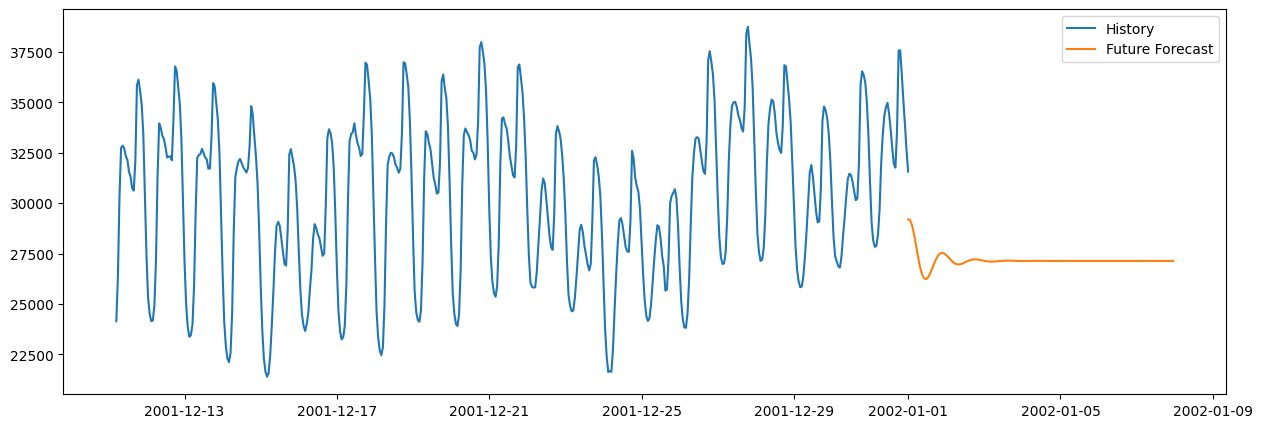

In [27]:
# Forecast next 168 hours (7 days) using ARIMA
future_forecast = fit.forecast(steps=168)

plt.figure(figsize=(15,5))
plt.plot(df.index[-500:], df['Value'].iloc[-500:], label="History")
plt.plot(pd.date_range(df.index[-1], periods=168, freq="H"), future_forecast, label="Future Forecast")
plt.legend()
plt.show()


/tmp/ipython-input-361111879.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  plt.plot(pd.date_range(df.index[-1], periods=168, freq="H"), future_preds,


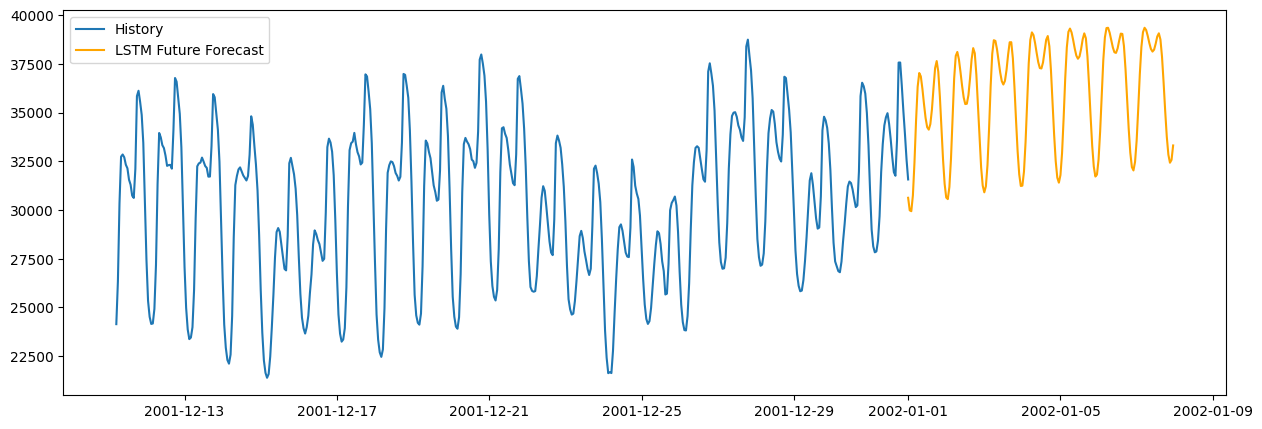

In [29]:
# Start with the last 24 hours of data
last_window = scaled[-24:].reshape(1, 24, 1)

future_preds = []

for _ in range(168):  # 7 days ahead
    next_pred = model.predict(last_window, verbose=0)
    next_pred = next_pred.reshape(1,1,1)  # reshape to match
    future_preds.append(next_pred[0,0,0])

    # Slide the window
    last_window = np.append(last_window[:,1:,:], next_pred, axis=1)

# Inverse scale back to MW
future_preds = scaler.inverse_transform(np.array(future_preds).reshape(-1,1))

# Plot
plt.figure(figsize=(15,5))
plt.plot(df.index[-500:], df['Value'].iloc[-500:], label="History")
plt.plot(pd.date_range(df.index[-1], periods=168, freq="H"), future_preds,
         label="LSTM Future Forecast", color="orange")
plt.legend()
plt.show()


/tmp/ipython-input-2630624215.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_index = pd.date_range(df.index[-1], periods=168, freq="H")


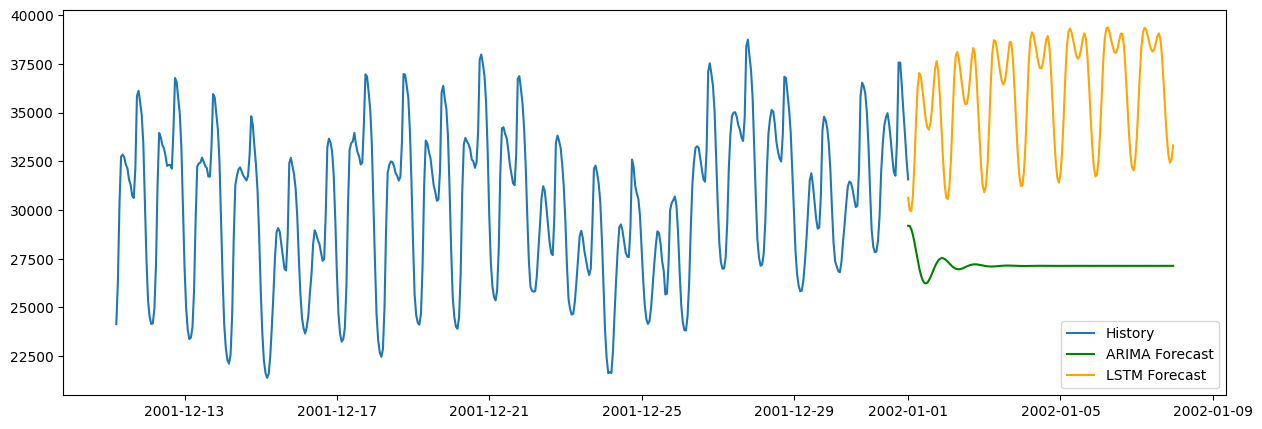

In [30]:
# Forecast with ARIMA
future_arima = fit.forecast(steps=168)

# Forecast with LSTM (already done → `future_preds`)
future_lstm = future_preds.flatten()

# Time index for next 168 hours
future_index = pd.date_range(df.index[-1], periods=168, freq="H")

plt.figure(figsize=(15,5))
plt.plot(df.index[-500:], df['Value'].iloc[-500:], label="History")
plt.plot(future_index, future_arima, label="ARIMA Forecast", color="green")
plt.plot(future_index, future_lstm, label="LSTM Forecast", color="orange")
plt.legend()
plt.show()


In [35]:
# Rebuild sequences for test set
X_test, y_test = [], []
test_scaled = scaled[-len(test)-24:]   # last test+24 hours

for i in range(24, len(test_scaled)):
    X_test.append(test_scaled[i-24:i])
    y_test.append(test_scaled[i])

X_test = np.array(X_test)
y_test = np.array(y_test)

# Predict with trained LSTM
pred_lstm = model.predict(X_test)

# Inverse transform to original scale
pred_lstm = scaler.inverse_transform(pred_lstm)
y_test = scaler.inverse_transform(y_test)

# Align index with predictions
aligned_index = test.index[-len(pred_lstm):]


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


In [36]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# MAE
mae_arima  = mean_absolute_error(test['Value'], pred_arima)
mae_lstm   = mean_absolute_error(y_test, pred_lstm)

# RMSE
rmse_arima = np.sqrt(mean_squared_error(test['Value'], pred_arima))
rmse_lstm  = np.sqrt(mean_squared_error(y_test, pred_lstm))

print("ARIMA → RMSE:", rmse_arima, "MAE:", mae_arima)
print("LSTM  → RMSE:", rmse_lstm, "MAE:", mae_lstm)


ARIMA → RMSE: 6982.404522247228 MAE: 5305.844526784264
LSTM  → RMSE: 630.2768350326177 MAE: 471.1354618765195
